**SECTION 1 - FINE TUNING CART-POLE**

In [ ]:
!pip install gym

In [ ]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

In [ ]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Hit:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Get:15 http://ppa

In [ ]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

In [ ]:
# Define the replay memory
replay_mem = ReplayMemory(capacity=3)

# Push some samples
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(1,1,1,1)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(2,2,2,2)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(3,3,3,3)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(4,4,4,4)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(5,5,5,5)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")

# Check the content of the memory
print('\nCONTENT OF THE MEMORY')
print(replay_mem.memory)

# Random sample
print('\nRANDOM SAMPLING')
for i in range(5):
  print(replay_mem.sample(2)) # Select 2 samples randomly from the memory

CURRENT MEMORY SIZE: 0
CURRENT MEMORY SIZE: 1
CURRENT MEMORY SIZE: 2
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3

CONTENT OF THE MEMORY
deque([(3, 3, 3, 3), (4, 4, 4, 4), (5, 5, 5, 5)], maxlen=3)

RANDOM SAMPLING
[(3, 3, 3, 3), (5, 5, 5, 5)]
[(3, 3, 3, 3), (4, 4, 4, 4)]
[(5, 5, 5, 5), (3, 3, 3, 3)]
[(3, 3, 3, 3), (5, 5, 5, 5)]
[(3, 3, 3, 3), (5, 5, 5, 5)]


In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                  nn.Linear(state_space_dim,64),
                  nn.ReLU(),
                  nn.Linear(64,128),
                  nn.ReLU(),
                  nn.Linear(128,action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [ ]:
# Define an example network
net = DQN(state_space_dim=4, action_space_dim=2)

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [ ]:
# Test if it works as expected
state = (0, 0, 0, 0)
epsilon = 0.5
chosen_action, q_values = choose_action_epsilon_greedy(net, state, epsilon)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 0
Q-VALUES: [ 0.16806805 -0.0349641 ]


In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [ ]:
state = (0, 0, 0, 0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 0
Q-VALUES: [ 0.16806805 -0.0349641 ]


Text(0, 0.5, 'Exploration profile (Softmax temperature)')

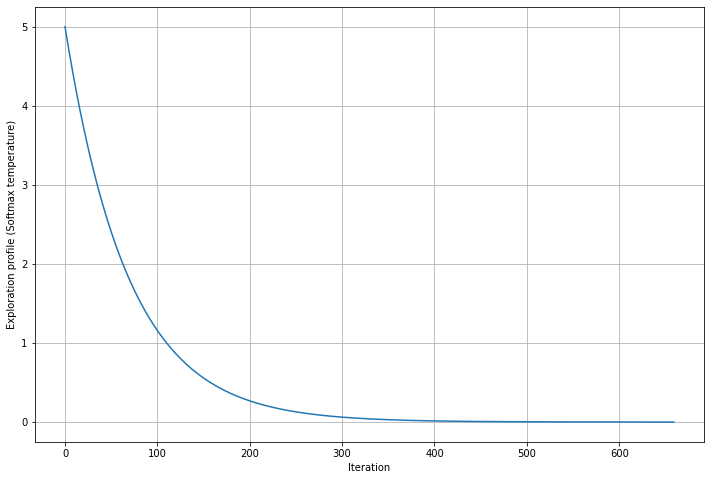

In [ ]:
### Define exploration profile
initial_value = 5
num_iterations = 660
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [ ]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()


EPISODE 1 - FINAL SCORE: 15.0
EPISODE 2 - FINAL SCORE: 15.0
EPISODE 3 - FINAL SCORE: 10.0
EPISODE 4 - FINAL SCORE: 9.0
EPISODE 5 - FINAL SCORE: 25.0
EPISODE 6 - FINAL SCORE: 20.0
EPISODE 7 - FINAL SCORE: 10.0
EPISODE 8 - FINAL SCORE: 30.0
EPISODE 9 - FINAL SCORE: 67.0
EPISODE 10 - FINAL SCORE: 13.0


In [ ]:
#show_videos()

In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.99   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 0.85   # Optimizer learning rate
target_net_update_steps = 5   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [ ]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [ ]:
# Training Loop
# Reward is not updated

# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

  0%|          | 0/660 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.927376314600751
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.855807469137697
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.785278142338101
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.715773235466689
Updating target network...
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.647277869093343
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.579777379907759
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.513257317580355
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.447703441668793
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.383101718569411
Updating target network...
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.319438318512953
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.256699612603924
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.194872169902954
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.133942754551535
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.0738983229385

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


Updating target network...
EPISODE: 41 - FINAL SCORE: 26 - Temperature: 2.784832596115958
EPISODE: 42 - FINAL SCORE: 33 - Temperature: 2.744383634845979
EPISODE: 43 - FINAL SCORE: 20 - Temperature: 2.704522184103599
EPISODE: 44 - FINAL SCORE: 14 - Temperature: 2.665239710452873
EPISODE: 45 - FINAL SCORE: 11 - Temperature: 2.6265278044037705
Updating target network...
EPISODE: 46 - FINAL SCORE: 17 - Temperature: 2.588378178611891
EPISODE: 47 - FINAL SCORE: 14 - Temperature: 2.5507826661043334
EPISODE: 48 - FINAL SCORE: 28 - Temperature: 2.5137332185313292
EPISODE: 49 - FINAL SCORE: 30 - Temperature: 2.4772219044432777
EPISODE: 50 - FINAL SCORE: 28 - Temperature: 2.4412409075927943
Updating target network...
EPISODE: 51 - FINAL SCORE: 15 - Temperature: 2.4057825252614355
EPISODE: 52 - FINAL SCORE: 12 - Temperature: 2.370839166610716
EPISODE: 53 - FINAL SCORE: 40 - Temperature: 2.3364033510570854
EPISODE: 54 - FINAL SCORE: 18 - Temperature: 2.3024677066705017
EPISODE: 55 - FINAL SCORE: 24

In [ ]:
# Training advance 
# Tweak reward &  modify the reward to improve the results.

# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # We apply a (linear) penalty when the cart is far from center
      pos_weight = 1
      reward = reward - pos_weight * np.abs(state[0]) 

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

  0%|          | 0/660 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 20 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.927376314600751
EPISODE: 3 - FINAL SCORE: 45 - Temperature: 4.855807469137697
EPISODE: 4 - FINAL SCORE: 22 - Temperature: 4.785278142338101
EPISODE: 5 - FINAL SCORE: 26 - Temperature: 4.715773235466689
Updating target network...
EPISODE: 6 - FINAL SCORE: 23 - Temperature: 4.647277869093343
EPISODE: 7 - FINAL SCORE: 21 - Temperature: 4.579777379907759
EPISODE: 8 - FINAL SCORE: 41 - Temperature: 4.513257317580355
EPISODE: 9 - FINAL SCORE: 22 - Temperature: 4.447703441668793
EPISODE: 10 - FINAL SCORE: 41 - Temperature: 4.383101718569411
Updating target network...
EPISODE: 11 - FINAL SCORE: 19 - Temperature: 4.319438318512953
EPISODE: 12 - FINAL SCORE: 17 - Temperature: 4.256699612603924
EPISODE: 13 - FINAL SCORE: 33 - Temperature: 4.194872169902954
EPISODE: 14 - FINAL SCORE: 13 - Temperature: 4.133942754551535
EPISODE: 15 - FINAL SCORE: 41 - Temperature: 4.0738983229385

In [ ]:
# Final Test
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 53.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 30.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 30.0
EPISODE 6 - FINAL SCORE: 59.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 30.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 59.0


In [ ]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.3.72.video000000.mp4



SHOWING VIDEO video/openaigym.video.3.72.video000001.mp4



SHOWING VIDEO video/openaigym.video.3.72.video000002.mp4



SHOWING VIDEO video/openaigym.video.3.72.video000003.mp4



SHOWING VIDEO video/openaigym.video.3.72.video000004.mp4



SHOWING VIDEO video/openaigym.video.3.72.video000005.mp4



SHOWING VIDEO video/openaigym.video.3.72.video000006.mp4



SHOWING VIDEO video/openaigym.video.3.72.video000007.mp4



SHOWING VIDEO video/openaigym.video.3.72.video000008.mp4



SHOWING VIDEO video/openaigym.video.3.72.video000009.mp4


**SECTION 2 - DIFFERENT GYM ENVIRONMENT ACROBOT**

## 1: Install and Import libraries

In [ ]:
!pip install gym

In [ ]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch import nn
from collections import deque,namedtuple

In [ ]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [ ]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

## 2: Instantiate environment

In [ ]:
import gym
env = gym.make('Acrobot-v1')
env.seed(0)

print(env.action_space)
print(env.observation_space)

Discrete(3)
Box(-28.274333953857422, 28.274333953857422, (6,), float32)


In [ ]:
import gym
env = gym.make('Acrobot-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 6
ACTION SPACE SIZE: 3


In [ ]:
env.action_space

Discrete(3)

In [ ]:
env.observation_space

Box(-28.274333953857422, 28.274333953857422, (6,), float32)

## 3: Random Agent

In [ ]:
def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

In [ ]:
env = gym.make('Acrobot-v1')
env.seed(0)
env = wrap_env(env, video_callable=lambda episode_id: True)

for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score > -500:
      # Choose a random action
      action = random.choice([0, 1, 2])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (-1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

EPISODE 1 - FINAL SCORE: -500.0
EPISODE 2 - FINAL SCORE: -500.0
EPISODE 3 - FINAL SCORE: -500.0
EPISODE 4 - FINAL SCORE: -500.0
EPISODE 5 - FINAL SCORE: -500.0
EPISODE 6 - FINAL SCORE: -500.0
EPISODE 7 - FINAL SCORE: -500.0
EPISODE 8 - FINAL SCORE: -500.0
EPISODE 9 - FINAL SCORE: -500.0
EPISODE 10 - FINAL SCORE: -500.0


In [ ]:
show_videos()


SHOWING VIDEO video/openaigym.video.6.72.video000000.mp4



SHOWING VIDEO video/openaigym.video.6.72.video000001.mp4



SHOWING VIDEO video/openaigym.video.6.72.video000002.mp4



SHOWING VIDEO video/openaigym.video.6.72.video000003.mp4



SHOWING VIDEO video/openaigym.video.6.72.video000004.mp4



SHOWING VIDEO video/openaigym.video.6.72.video000005.mp4



SHOWING VIDEO video/openaigym.video.6.72.video000006.mp4



SHOWING VIDEO video/openaigym.video.6.72.video000007.mp4



SHOWING VIDEO video/openaigym.video.6.72.video000008.mp4



SHOWING VIDEO video/openaigym.video.6.72.video000009.mp4


## 4: DQN

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        # Define a queue with maxlen "capacity"
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, next_state, reward):
        # Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        # Randomly select "batch_size" samples and return the selection
        return random.sample(self.memory,batch_size)

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                  nn.Linear(state_space_dim,64),
                  nn.ReLU(),
                  nn.Linear(64,128),
                  nn.ReLU(),
                  nn.Linear(128,action_space_dim)
                )

    def forward(self, x):
        x = x.to(device)
        return self.linear(x)

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions (this list includes all the actions but the optimal one)
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly from non_optimal_actions
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.cpu().numpy()

In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out/temperature, dim=0).cpu().numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    action = np.random.choice(all_possible_actions,p=softmax_out)
    
    return action, net_out.cpu().numpy()

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

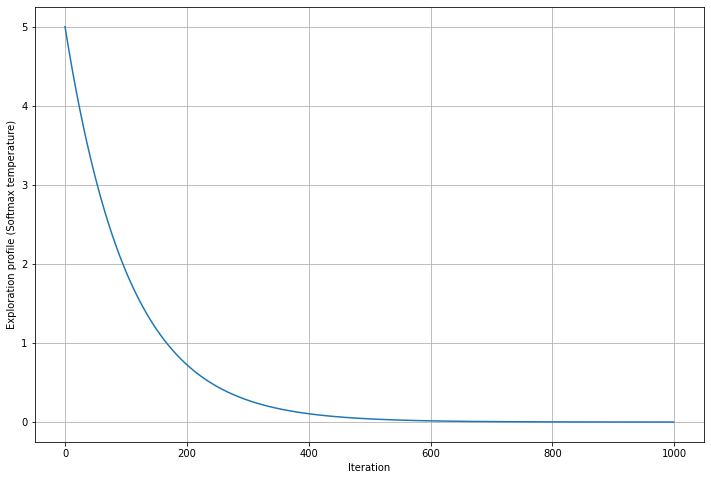

In [ ]:
### Define exploration profile
initial_value = 5
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [ ]:
env = gym.make('Acrobot-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 6
ACTION SPACE SIZE: 3


In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)


gamma = 0.99   
replay_memory_capacity = 10000   # Replay memory capacity

lr = 1e-3
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 256   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [ ]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim).to(device)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim).to(device)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32, device=device)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64, device=device)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32, device=device)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32, device=device) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1).cuda())

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size, device=device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1)# Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [ ]:
# Initialize the Gym environment
env = gym.make('Acrobot-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)


env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

plotting_rewards=[]

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # Update the final score (+1 for each step)
      score += reward

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None
      
      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
    
    plotting_rewards.append(score)
    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: -500.0 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: -500.0 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: -500.0 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: -500.0 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: -500.0 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: -500.0 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: -500.0 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: -500.0 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: -500.0 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: -500.0 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: -500.0 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: -500.0 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: -500.0 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: -500.0 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: -50

In [ ]:
#show_videos()

No handles with labels found to put in legend.


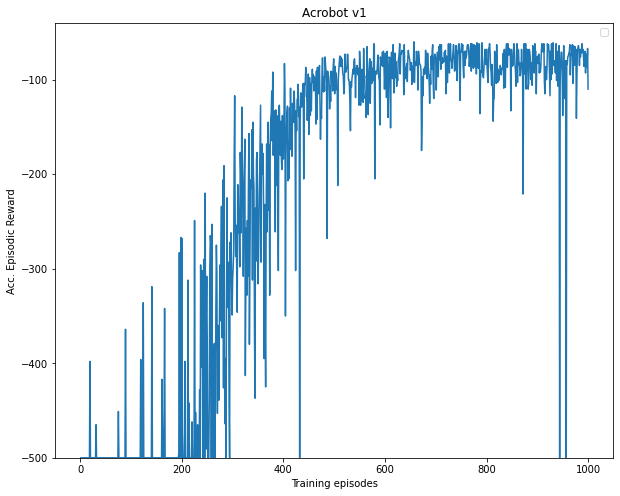

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.plot(range(1,1001),plotting_rewards)
plt.xlabel('Training episodes')
plt.ylabel('Acc. Episodic Reward')
plt.ylim([-500,-40])
#plt.grid()
plt.legend()
plt.title('Acrobot v1')
plt.show()

In [ ]:
# Initialize the Gym environment
env = gym.make('Acrobot-v1') 
env.seed(1)


env = wrap_env(env, video_callable=lambda episode_id: True) 

plotting_rewards2=[]

for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    plotting_rewards2.append(score)
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: -93.0
EPISODE 2 - FINAL SCORE: -91.0
EPISODE 3 - FINAL SCORE: -68.0
EPISODE 4 - FINAL SCORE: -70.0
EPISODE 5 - FINAL SCORE: -69.0
EPISODE 6 - FINAL SCORE: -125.0
EPISODE 7 - FINAL SCORE: -135.0
EPISODE 8 - FINAL SCORE: -68.0
EPISODE 9 - FINAL SCORE: -70.0
EPISODE 10 - FINAL SCORE: -67.0


In [ ]:
show_videos()


SHOWING VIDEO video/openaigym.video.6.72.video000000.mp4



SHOWING VIDEO video/openaigym.video.6.72.video000001.mp4



SHOWING VIDEO video/openaigym.video.6.72.video000002.mp4



SHOWING VIDEO video/openaigym.video.6.72.video000003.mp4



SHOWING VIDEO video/openaigym.video.6.72.video000004.mp4



SHOWING VIDEO video/openaigym.video.6.72.video000005.mp4



SHOWING VIDEO video/openaigym.video.6.72.video000006.mp4



SHOWING VIDEO video/openaigym.video.6.72.video000007.mp4



SHOWING VIDEO video/openaigym.video.6.72.video000008.mp4



SHOWING VIDEO video/openaigym.video.6.72.video000009.mp4
